In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
import numpy as np
import utils
from Model import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from MyDataLoader import MyDataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer, Baseline
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
import pytorch_lightning as pl

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Stellantis and WLN have a lot of missing prices compared to the other stocks in the CAC40: we exclude them from this analysis.

In [2]:
dataloader = MyDataLoader()
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
column_names = dataloader.load_feature_names()

In [4]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))

In [23]:
model_1 = Model("Lasso", "regression", Lasso(0.05))
model_2 = Model("LogisticRegression", "classification", LogisticRegression(C = 0.2, penalty="l1", solver="saga"))

In [6]:
models = [model_1, model_2]
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [7]:
returns = dataloader.load_returns()

In [20]:
# precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
# prec_mat = precision_matrix_builder.get_precision_matrix()

In [21]:
import pickle
with open("precision_mat.pkl", "rb") as f:
    prec_mat = pickle.load(f)

In [22]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
from Forecaster import Forecaster
forecaster = Forecaster(full_dataset, stock_names, time_index, valid_size=66, test_size=66, n_splits=10)
forecasts_valid, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

10it [01:55, 11.60s/it]


In [25]:
weights_test_full_lasso = weights_test["Lasso"]
weights_test_full_logistic = weights_test["LogisticRegression"]

Text(0, 0.5, 'MSE')

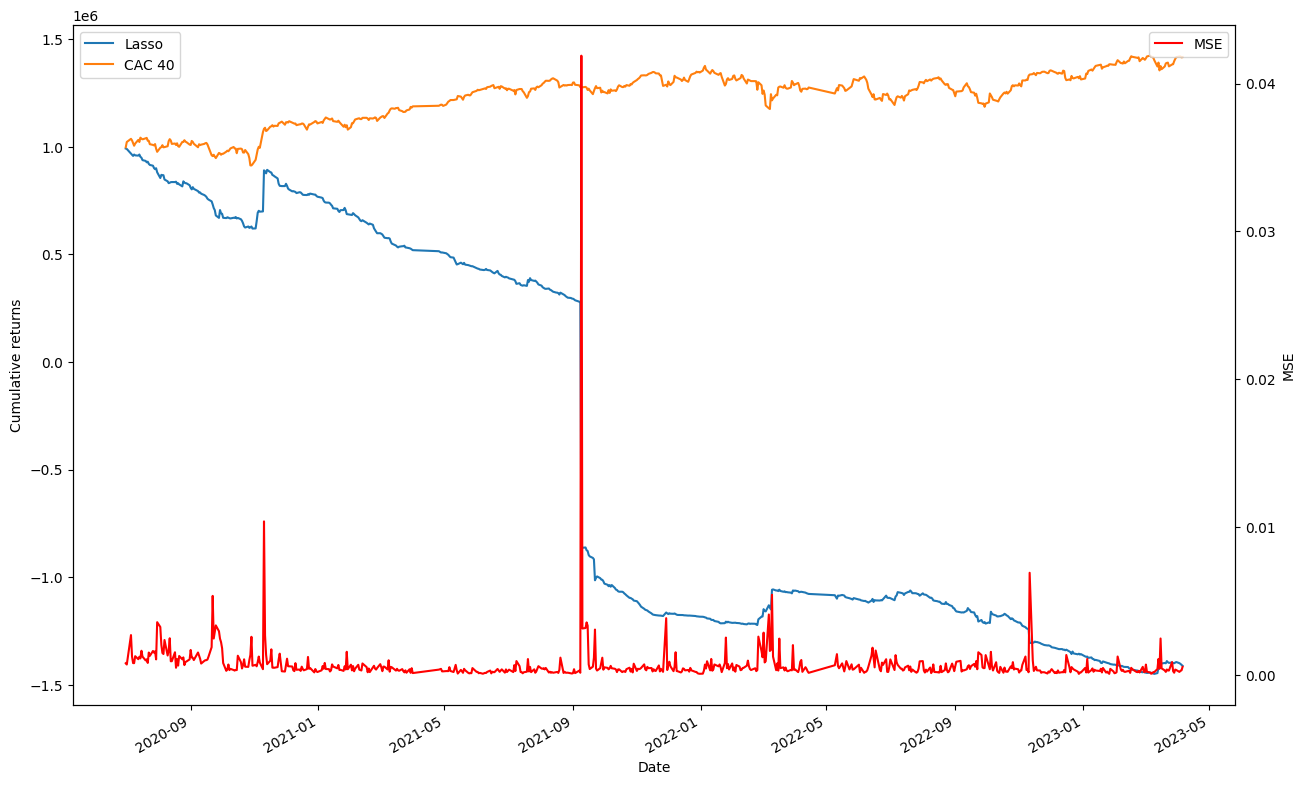

In [31]:
backtest = BackTester(weights_test_full_lasso, returns, capital, risk_free, benchmark=benchmark_returns, name = "Lasso")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["Lasso"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Lasso", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [34]:
cum_returns["MSE"].sum()

0.46259984561621637

In [32]:
backtest_statistics

Yearly excess returns         -0.922443
Yearly standard deviation      0.726573
Max DD                       320.296158
Yearly Sharpe                 -1.269582
Yearly Calmar                 -0.002880
Yearly Sortino                -1.133789
Daily Turnover                 0.568275
dtype: float64

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

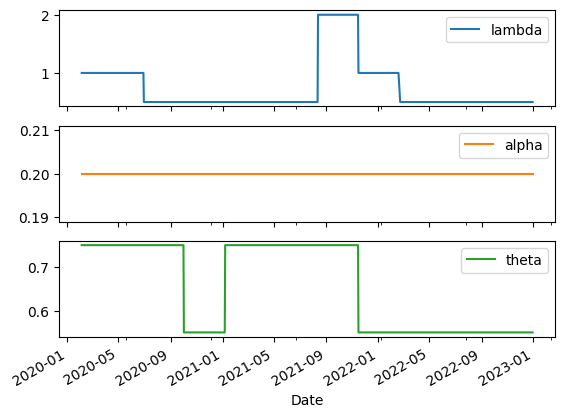

In [27]:
opt_param_dict["Lasso"].plot(subplots = True)

Text(0, 0.5, 'Misclassification rate')

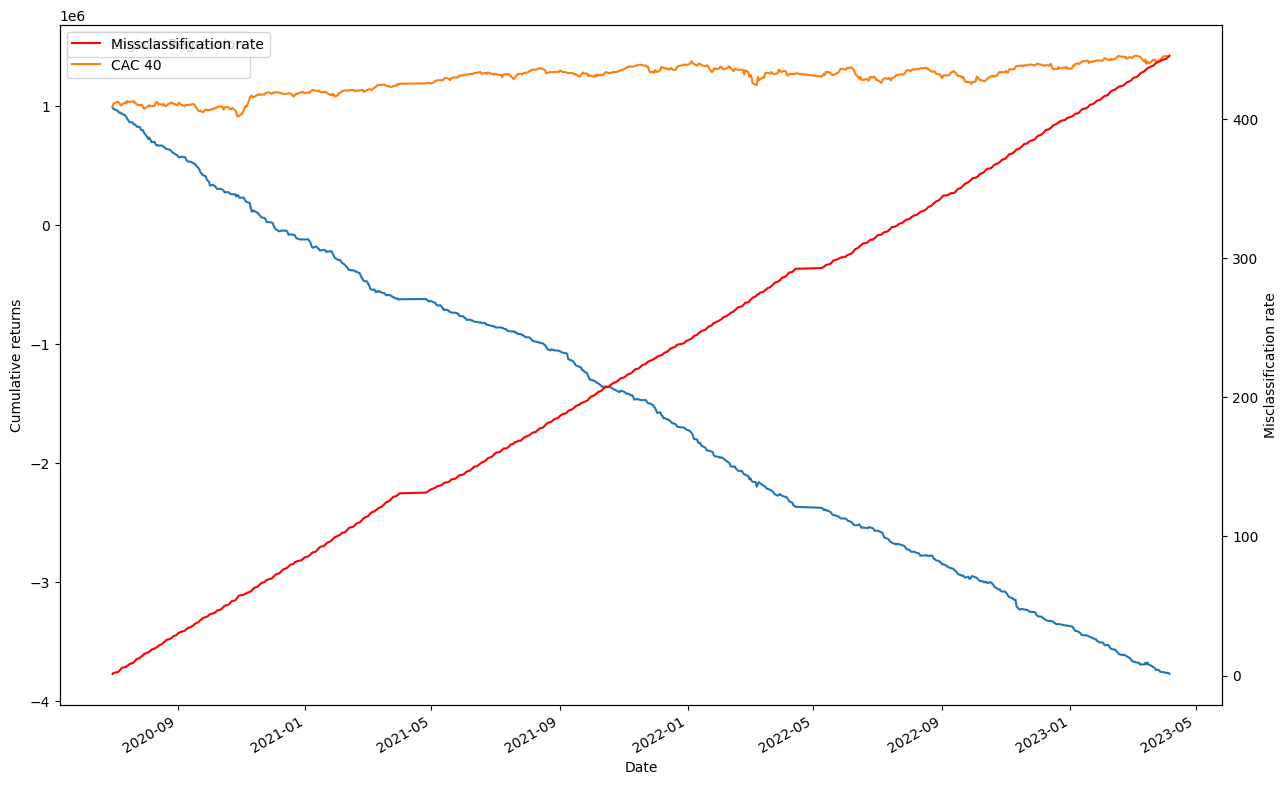

In [28]:
backtest = BackTester(weights_test_full_logistic, returns, capital, risk_free, benchmark = benchmark_returns, name = "Logistic Regression")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["Missclassification rate"] = (forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Logistic Regression", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("Misclassification rate")

In [29]:
(forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.6746012759170656

In [30]:
backtest_statistics

Yearly excess returns         -1.823427
Yearly standard deviation      0.133675
Max DD                       345.746868
Yearly Sharpe                -13.640795
Yearly Calmar                 -0.005274
Yearly Sortino               -15.904764
Daily Turnover                 0.757855
dtype: float64